## Generating lists of genes for each cluster).

Click <a href=#dist_to_centroids_results>here</a> to jump directly to the results and <a href=#most_biased_genes>here</a> for the most biased genes within each cluster (links not working when the notebook is displayed in gitlab).

In [1]:
from pathlib import Path
from random import seed
seed(123)

In [2]:
from yaml import safe_load as yload

In [3]:
from libcodonusage import (
    aa2colour, columns_by_aa,
    extract_top_genes_from_cluster,
    find_most_biased_genes,
    find_valley,
    load_bias_table,
    plot_codon_usage_for_gene_list,
    star2stop,
    violin_usage_by_clusters,
    violin_with_thresh,
    write_cluster_lists)

In [4]:
with open("configs/codon_usage_Ecoli_first30.yaml") as fh:
    config = yload(fh)
config

{'species': 'Ecoli',
 'assembly': 'GCF_000005845.2_ASM584v2',
 'seq_id_kw': 'protein_id',
 'alt_tag_kw': 'locus_tag',
 'out_dir': 'codon_usage_first30',
 'kwargs': {'max_aas': 30}}

In [5]:
species = config["species"]
assembly = config["assembly"]
seq_id_kw = config["seq_id_kw"]
alt_tag_kw = config["alt_tag_kw"]

In [6]:
usage_dir = Path(config["out_dir"]).joinpath(
    "usage_computations", species, assembly)

In [7]:
scub_by_aa_noMW = load_bias_table(
    usage_dir.joinpath(
        "standardized_codon_usage_biases_by_aa_with_aa_based_clusterings.tsv"),
    nb_info_cols=13,
    nb_cluster_series=2)

In [8]:
# Move sequence identifier to the front of the index columns
scub_by_aa_noMW = scub_by_aa_noMW.reorder_levels([
    seq_id_kw,
    *[name for name in scub_by_aa_noMW.index.names if name != seq_id_kw]])

In [9]:
scub_by_aa_noMW.head(3)

A  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          GCA   
protein_id  gene locus_tag chrom start end  length start_codon expected_start_aa first_stop nb_stops start_upstream end_downstream cluster_A_full_bias cluster_R_full_bias cluster_N_full_bias cluster_D_full_bias cluster_C_full_bias cluster_Q_full_bias cluster_E_full_bias cluster_G_full_bias cluster_H_full_bias cluster_I_full_bias cluster_L_full_bias cluster_K_full_bias cluster_F_full_bias cluster_P_full_bias cluster_S_full_bias cluster_T_full_bias cluster_Y_full_bias cluster_V_full_bias cluster_*_full_bias cluster_A_highest_bias cluster_R_highest_bias cluster_N_highest_bias cluster_D_highest_bias cluster_C_highest_bias cluster_Q_highest_bias cluster_E_highest_bias cluster_G_highest_bias cluster_H_highest_bias cluster_I_highest_bias cluster_L_highest_bias cluster_K_highest_bias cluster_F_highest_bias cluster_P_highest_bias cluster_S_highest_bias cluster_T_highest_bias cluster_Y_highest_bias cluster_V_highest_bias cluster_*_highest_bias             
NP_414542.1 thrL b0001     NC    189   255  66     ATG         M                 0          0        False          False          A_GCG               R_CGC               N_AAC               D_GAT               C_TGC               Q_CAG               E_GAA               G_GGT               H_CAT               I_ATT               L_CTG               K_AAA               F_TTT               P_CCG               S_AGC               T_ACC               Y_TAT               V_GTG               *_TGA               A_GCG                  R_CGC                  N_AAC                  D_GAT                  C_TGT                  Q_CAG                  E_GAG                  G_GGT                  H_CAT                  I_ATT                  L_TTG                  K_AAA                  F_TTT                  P_CCT                  S_AGC                  T_ACC                  Y_TAT                  V_GTT                  *_TGA                  -0.822990   
NP_414543.1 thrA b0002     NC    336   2799 90     ATG         M                 0          0        False          False          A_GCA               R_CGT               N_AAT               D_GAT               C_TGC               Q_CAG               E_GAA               G_GGC               H_CAT               I_ATT               L_CTG               K_AAG               F_TTC               P_CCG               S_AGC               T_ACA               Y_TAT               V_GTG               *_TAA               A_GCA                  R_AGG                  N_AAT                  D_GAT                  C_TGT                  Q_CAG                  E_GAA                  G_GGT                  H_CAT                  I_ATT                  L_TTG                  K_AAG                  F_TTC                  P_CCT                  S_TCA                  T_ACA                  Y_TAT                  V_GTG                  *_TGA                   0.855955   
NP_414544.1 thrB b0003     NC    2800  3733 90     ATG         M                 0          0        False          False          A_GCG               

In [10]:
from IPython.display import display
from IPython.core.display import HTML, Markdown
from IPython.display import FileLink

In [11]:
# python3 -m pip install markdown
from markdown import markdown

In [12]:
import matplotlib.pyplot as plt

In [13]:
gene_lists_dir = usage_dir.joinpath("gene_lists")
gene_lists_dir.mkdir(parents=True, exist_ok=True)

In [14]:
clusters_dir = gene_lists_dir.joinpath("closest_full_bias_clusters")
clusters_dir.mkdir(parents=True, exist_ok=True)
md_reports = []
for aa in aa2colour.keys():
    if aa == "M" or aa == "W":
        continue
    md_reports.append(write_cluster_lists(
        scub_by_aa_noMW, aa, clusters_dir,
        "cluster_{aa}_full_bias",
        "Standardized codon usage bias (by aa, cluster {cluster})",
        alt_tag_kw=alt_tag_kw))
# Not rendered in gitlab for security reasons
# Markdown("\n\n\n\n".join(md_reports))

### Clusters defined using pre-defined "centroids" <a name="dist_to_centroids_results"></a>

In [15]:
display(HTML(markdown("\n\n\n\n".join(md_reports))))

## Further separating genes based on density distribution of usage biases

Within a given cluster, when the usage bias distribution for a codon appears to be multimodal, we want to be able to extract the group having the most extreme usage bias values.

We can try to do this by finding a minimum in the density distribution of usage biases for the codon, and use it as a threshold.

In [16]:
md_reports = []
for (aa, columns) in columns_by_aa.items():
    if aa in {"M", "W"}:
        continue
    print(f"Dealing with {aa}")
    md_reports.append(f"* Most biased genes in clusters for {aa}:\n\n")
    for (_, codon) in columns:
        print(f"    {codon}")
        md_reports.append(extract_top_genes_from_cluster(
            scub_by_aa_noMW, aa, codon, clusters_dir,
            alt_tag_kw=alt_tag_kw))

Dealing with K
    AAA
    AAG
Dealing with N
    AAC
    AAT
Bottom-most 2 values had to be discarded in order to avoid a negative threshold for the cluster N_AAT.
Dealing with T
    ACA
Bottom-most 1 values had to be discarded in order to avoid a negative threshold for the cluster T_ACA.
669 genes were found with a high bias for ACA but not belonging to the cluster T_ACA.
    ACC
Bottom-most 4 values had to be discarded in order to avoid a negative threshold for the cluster T_ACC.
    ACG
Bottom-most 3 values had to be discarded in order to avoid a negative threshold for the cluster T_ACG.
598 genes were found with a high bias for ACG but not belonging to the cluster T_ACG.
    ACT
Bottom-most 2 values had to be discarded in order to avoid a negative threshold for the cluster T_ACT.
Dealing with R
    AGA
216 genes were found with a high bias for AGA but not belonging to the cluster R_AGA.
    AGG
120 genes were found with a high bias for AGG but not belonging to the cluster R_AGG.
 

### Most biased genes within each cluster <a name="most_biased_genes"></a>

In [17]:
display(HTML(markdown("\n\n\n\n".join(md_reports))))

Removal of bottom values were necessary to avoid a threshold at the bottom of the distribution for these clusters:

* `N_AAT` (2 values removed)
* `T_ACA` (1 values removed)
* `T_ACC` (4 values removed)
* `T_ACG` (3 values removed)
* `T_ACT` (2 values removed)
* `R_CGC` (1 values removed)
* `R_CGT` (9 values removed)
* `S_AGC` (2 values removed)
* `S_TCC` (1 values removed)
* `S_TCT` (1 values removed)
* `I_ATC` (3 values removed)
* `I_ATT` (2 values removed)
* `Q_CAA` (3 values removed)
* `Q_CAG` (2 values removed)
* `H_CAT` (1 values removed)
* `P_CCA` (1 values removed)
* `P_CCG` (1 values removed)
* `P_CCT` (2 values removed)
* `L_CTG` (4 values removed)
* `E_GAA` (1 values removed)
* `E_GAG` (1 values removed)
* `D_GAC` (2 values removed)
* `D_GAT` (1 values removed)
* `A_GCG` (2 values removed)
* `A_GCT` (1 values removed)
* `G_GGC` (4 values removed)
* `G_GGG` (1 values removed)
* `G_GGT` (1 values removed)
* `V_GTG` (2 values removed)
* `V_GTT` (1 values removed)
* `Y_TAT` (2 values removed)
* `C_TGC` (2 values removed)
* `F_TTC` (2 values removed)
* `F_TTT` (3 values removed)

After visulal inspection of the violin plots, possible issues with the threshold determination could concern the following other clusters:

Threshold at the lower tail of the distribution:

* `A_GCA`
* `A_GCT`
* `F_TTC`
* `G_GGG`
* `H_CAC`
* `I_ATA`
* `L_CTA`
* `L_CTC`
* `P_CCA`
* `R_AGA`
* `R_AGG`
* `R_CGA`
* `S_TCA`
* `S_TCC`
* `S_TCG`
* `V_GTA`
* `T_ACA`
* `T_ACG`

Very large tail:

* `A_GCA`
* `A_GCC`
* `A_GCT`
* `C_TGT`
* `D_GAC`
* `D_GAT`
* `E_GAA`
* `E_GAG`
* `F_TTC`
* `F_TTT`
* `G_GGA`
* `G_GGC`
* `G_GGG`
* `G_GGT`
* `H_CAC`
* `H_CAT`
* `I_ATA`
* `I_ATC`
* `I_ATT`
* `K_AAA`
* `K_AAG`
* `L_CTA`
* `L_CTC`
* `L_CTT`
* `N_AAC`
* `N_AAT`
* `P_CCA`
* `P_CCC`
* `P_CCG`
* `P_CCT`
* `Q_CAA`
* `Q_CAG`
* `R_AGA`
* `R_AGG`
* `R_CGA`
* `R_CGC`
* `R_CGG`
* `R_CGT`
* `S_AGT`
* `S_TCA`
* `S_TCC`
* `S_TCG`
* `S_TCT`
* `T_ACA`
* `T_ACC`
* `T_ACG`
* `T_ACT`
* `V_GTA`
* `V_GTC`
* `V_GTG`
* `V_GTT`
* `Y_TAC`
* `Y_TAT`

No dispersion of values:

* `*_TAG`
* `*_TGA`

Not very clear tail:

* `*_TAA`

Bottom-most 4 values had to be discarded in order to avoid a negative threshold for the cluster A_GCA.
755 genes were found with a high bias for GCA but not belonging to the cluster A_GCA.
Bottom-most 1 values had to be discarded in order to avoid a negative threshold for the cluster A_GCT.
791 genes were found with a high bias for GCT but not belonging to the cluster A_GCT.


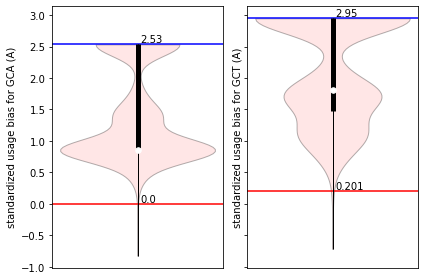

In [18]:
fig, axes = plt.subplots(ncols=2, sharey=True)
(aa, codon) = ("A", "GCA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("A", "GCT")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1], alt_tag_kw=alt_tag_kw)

Bottom-most 2 values had to be discarded in order to avoid a negative threshold for the cluster F_TTC.
21 genes were found with a high bias for TTC but not belonging to the cluster F_TTC.


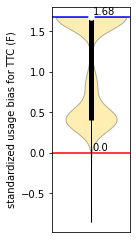

In [19]:
(aa, codon) = ("F", "TTC")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, alt_tag_kw=alt_tag_kw)

Bottom-most 1 values had to be discarded in order to avoid a negative threshold for the cluster G_GGG.
485 genes were found with a high bias for GGG but not belonging to the cluster G_GGG.


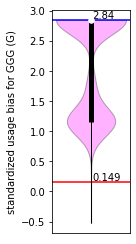

In [20]:
(aa, codon) = ("G", "GGG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, alt_tag_kw=alt_tag_kw)

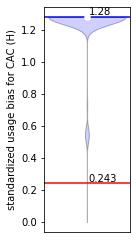

In [21]:
(aa, codon) = ("H", "CAC")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, alt_tag_kw=alt_tag_kw)

582 genes were found with a high bias for ATA but not belonging to the cluster I_ATA.


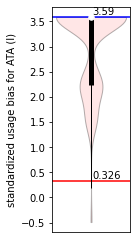

In [22]:
(aa, codon) = ("I", "ATA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, alt_tag_kw=alt_tag_kw)

424 genes were found with a high bias for CTA but not belonging to the cluster L_CTA.
1161 genes were found with a high bias for CTC but not belonging to the cluster L_CTC.


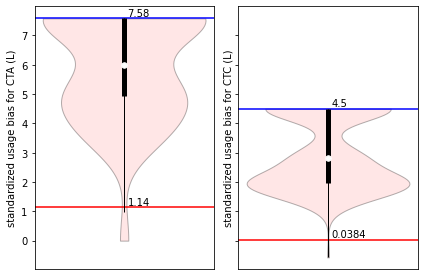

In [23]:
fig, axes = plt.subplots(ncols=2, sharey=True)
(aa, codon) = ("L", "CTA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("L", "CTC")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1], alt_tag_kw=alt_tag_kw)

Bottom-most 1 values had to be discarded in order to avoid a negative threshold for the cluster P_CCA.
260 genes were found with a high bias for CCA but not belonging to the cluster P_CCA.


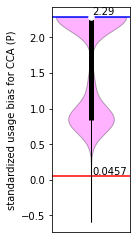

In [24]:
(aa, codon) = ("P", "CCA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, alt_tag_kw=alt_tag_kw)

216 genes were found with a high bias for AGA but not belonging to the cluster R_AGA.
120 genes were found with a high bias for AGG but not belonging to the cluster R_AGG.
311 genes were found with a high bias for CGA but not belonging to the cluster R_CGA.


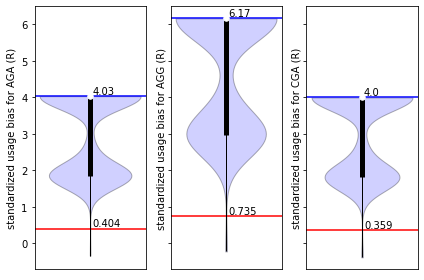

In [25]:
fig, axes = plt.subplots(ncols=3, sharey=True)
(aa, codon) = ("R", "AGA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("R", "AGG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("R", "CGA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[2], alt_tag_kw=alt_tag_kw)

594 genes were found with a high bias for TCA but not belonging to the cluster S_TCA.
Bottom-most 1 values had to be discarded in order to avoid a negative threshold for the cluster S_TCC.
742 genes were found with a high bias for TCC but not belonging to the cluster S_TCC.
396 genes were found with a high bias for TCG but not belonging to the cluster S_TCG.


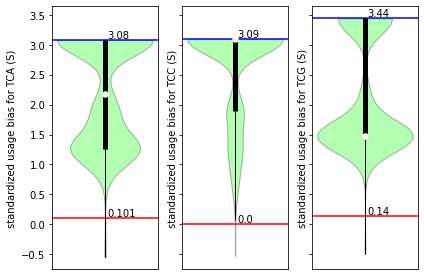

In [26]:
fig, axes = plt.subplots(ncols=3, sharey=True)
(aa, codon) = ("S", "TCA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("S", "TCC")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("S", "TCG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[2], alt_tag_kw=alt_tag_kw)

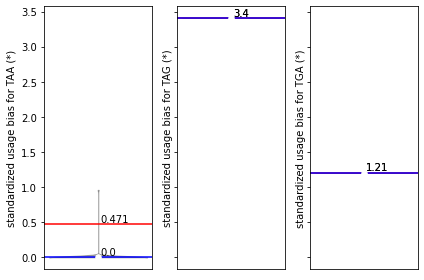

In [27]:
fig, axes = plt.subplots(ncols=3, sharey=True)
(aa, codon) = ("*", "TAA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[0], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("*", "TAG")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[1], alt_tag_kw=alt_tag_kw)
(aa, codon) = ("*", "TGA")
_ = extract_top_genes_from_cluster(
    scub_by_aa_noMW, aa, codon, clusters_dir,
    savefig=False, axis=axes[2], alt_tag_kw=alt_tag_kw)

### Testing the plotting of violin plots from a list of genes

    - Genes from codon_usage/usage_computations/Ecoli/GCF_000005845.2_ASM584v2/gene_lists/closest_full_bias_clusters/stop/stop_TGA.txt:

    - Genes from codon_usage/usage_computations/Ecoli/GCF_000005845.2_ASM584v2/gene_lists/closest_full_bias_clusters/stop/stop_TAG.txt:

    - Genes from codon_usage/usage_computations/Ecoli/GCF_000005845.2_ASM584v2/gene_lists/closest_full_bias_clusters/stop/stop_TAA.txt:




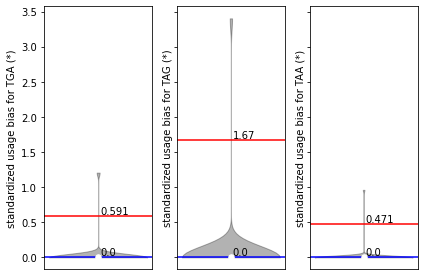

In [28]:
fig, axes = plt.subplots(ncols=3, sharey=True)
md_report = ""
md_report += plot_codon_usage_for_gene_list(
    "codon_usage/usage_computations/Ecoli/GCF_000005845.2_ASM584v2/gene_lists/closest_full_bias_clusters/stop/stop_TGA.txt",
    scub_by_aa_noMW, "*", "TGA",
    axis=axes[0], savefig=False, alt_tag_kw=alt_tag_kw)
md_report += plot_codon_usage_for_gene_list(
    "codon_usage/usage_computations/Ecoli/GCF_000005845.2_ASM584v2/gene_lists/closest_full_bias_clusters/stop/stop_TAG.txt",
    scub_by_aa_noMW, "*", "TAG", axis=axes[1], savefig=False, alt_tag_kw=alt_tag_kw)
md_report += plot_codon_usage_for_gene_list(
    "codon_usage/usage_computations/Ecoli/GCF_000005845.2_ASM584v2/gene_lists/closest_full_bias_clusters/stop/stop_TAA.txt",
    scub_by_aa_noMW, "*", "TAA", axis=axes[2], savefig=False, alt_tag_kw=alt_tag_kw)
print(md_report)
#plt.show()